In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test

In [3]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
# fix random seed for reproducibility
np.random.seed(42)

In [6]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [7]:
%%time
X_lt_FNM128, y_lt_FNM128, X_rt_FNM128, y_rt_FNM128, X_lb_FNM128, y_lb_FNM128, X_rb_FNM128, y_rb_FNM128, X_ct_FNM128, y_ct_FNM128 \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/France_New_ByMeaning_128_3dim",
                                ["GazolineStation", "Hotel", "Parking", "Restaurant", "Taxi", "TollRoad", "Transport"])

Wall time: 17.4 s


In [85]:
# so, let's try another one - there will be neuron net for each part

In [8]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [9]:
### Xception, with retrain

def run_Xception_with_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = Xception(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = True
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=10, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 229383    
Total params: 21,090,863
Trainable params: 21,036,335
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 54s 17ms/step - loss: 1.5361 - acc: 0.4934 - val_loss: 2.5115 - val_acc: 0.4062
Epoch 2/300
3123/3123 [==============================] - 40s 13ms/st

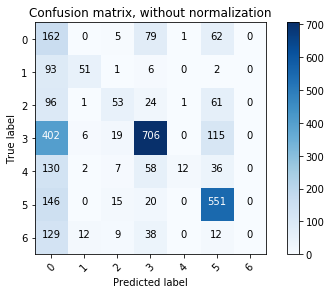

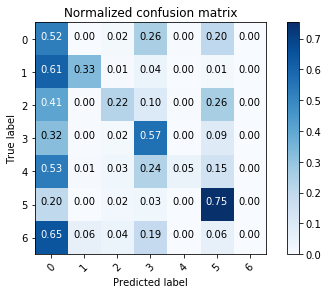

Confusion matrix, without normalization
[[14  0  1 17  0  3  0]
 [11  5  0  2  0  0  0]
 [ 5  0  6  1  0 15  0]
 [46  1  4 75  1 12  0]
 [18  0  3  3  0  4  0]
 [21  0  0  4  0 57  0]
 [16  1  2  3  0  1  0]]
Normalized confusion matrix
[[0.4        0.         0.02857143 0.48571429 0.         0.08571429
  0.        ]
 [0.61111111 0.27777778 0.         0.11111111 0.         0.
  0.        ]
 [0.18518519 0.         0.22222222 0.03703704 0.         0.55555556
  0.        ]
 [0.33093525 0.00719424 0.02877698 0.53956835 0.00719424 0.08633094
  0.        ]
 [0.64285714 0.         0.10714286 0.10714286 0.         0.14285714
  0.        ]
 [0.25609756 0.         0.         0.04878049 0.         0.69512195
  0.        ]
 [0.69565217 0.04347826 0.08695652 0.13043478 0.         0.04347826
  0.        ]]


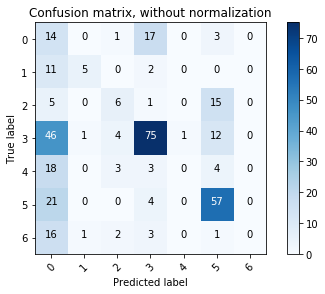

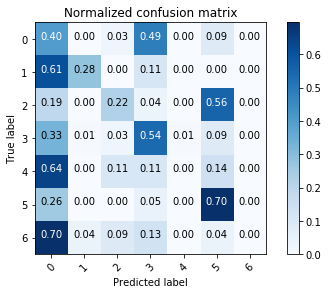

Wall time: 13min 32s


In [10]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_FNM128, y_ct_FNM128, num_categories=7)


model_ct, history_ct, test_scores_ct = run_Xception_with_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [12]:
print("center result accuracy:", test_scores_ct[1])

center result accuracy: 0.5482954545454546


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 229383    
Total params: 21,090,863
Trainable params: 21,036,335
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 57s 18ms/step - loss: 1.6110 - acc: 0.4934 - val_loss: 3.4682 - val_acc: 0.4886
Epoch 2/300
3123/3123 [==============================] - 41s 13ms/st

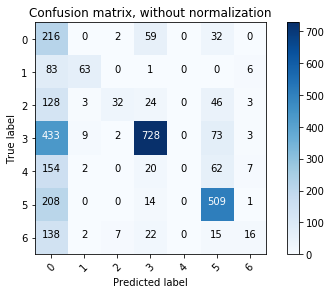

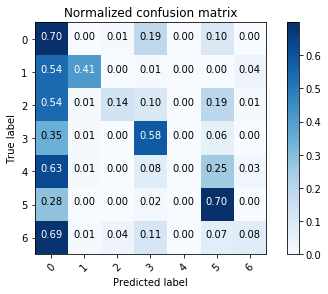

Confusion matrix, without normalization
[[23  0  0  7  0  5  0]
 [ 8  8  0  0  0  0  2]
 [ 8  0  6  0  0 13  0]
 [51  0  0 75  0 12  1]
 [19  0  0  0  0  7  2]
 [30  0  0  0  0 52  0]
 [16  2  3  0  0  0  2]]
Normalized confusion matrix
[[0.65714286 0.         0.         0.2        0.         0.14285714
  0.        ]
 [0.44444444 0.44444444 0.         0.         0.         0.
  0.11111111]
 [0.2962963  0.         0.22222222 0.         0.         0.48148148
  0.        ]
 [0.36690647 0.         0.         0.53956835 0.         0.08633094
  0.00719424]
 [0.67857143 0.         0.         0.         0.         0.25
  0.07142857]
 [0.36585366 0.         0.         0.         0.         0.63414634
  0.        ]
 [0.69565217 0.08695652 0.13043478 0.         0.         0.
  0.08695652]]


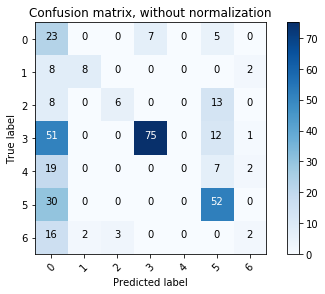

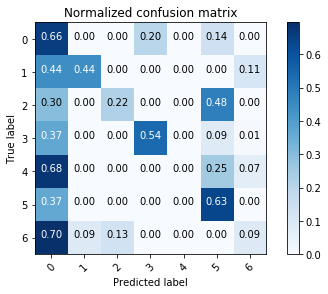

Wall time: 14min 9s


In [14]:
%%time
model_ct_1, history_ct_1, test_scores_ct_1 = run_Xception_with_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [18]:
print("center result accuracy:", test_scores_ct_1[1])

center result accuracy: 0.5767045454545454


In [16]:
model_ct = model_ct_1
history_ct = history_ct_1
test_scores_ct = test_scores_ct_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 229383    
Total params: 21,090,863
Trainable params: 21,036,335
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 57s 18ms/step - loss: 1.8245 - acc: 0.4070 - val_loss: 9.2305 - val_acc: 0.3949
Epoch 2/300
3123/3123 [==============================] - 41s 13ms/st

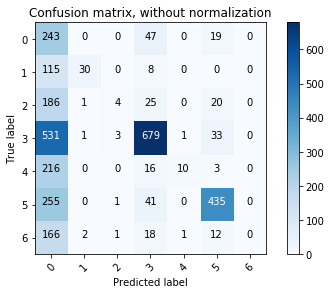

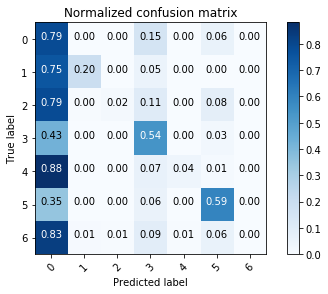

Confusion matrix, without normalization
[[23  0  0 10  0  2  0]
 [16  0  0  2  0  0  0]
 [15  0  0  3  0  9  0]
 [67  0  0 68  0  4  0]
 [11  0 11  2  1  3  0]
 [34  0  0  1  0 47  0]
 [21  0  0  2  0  0  0]]
Normalized confusion matrix
[[0.65714286 0.         0.         0.28571429 0.         0.05714286
  0.        ]
 [0.88888889 0.         0.         0.11111111 0.         0.
  0.        ]
 [0.55555556 0.         0.         0.11111111 0.         0.33333333
  0.        ]
 [0.48201439 0.         0.         0.48920863 0.         0.02877698
  0.        ]
 [0.39285714 0.         0.39285714 0.07142857 0.03571429 0.10714286
  0.        ]
 [0.41463415 0.         0.         0.01219512 0.         0.57317073
  0.        ]
 [0.91304348 0.         0.         0.08695652 0.         0.
  0.        ]]


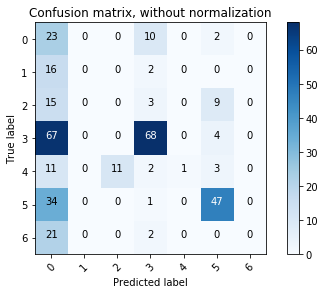

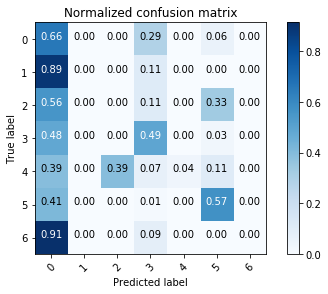

Wall time: 21min 57s


In [19]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_FNM128, y_lt_FNM128, num_categories=7)


model_lt, history_lt, test_scores_lt = run_Xception_with_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [20]:
print("left_top result accuracy:", test_scores_lt[1])

left_top result accuracy: 0.5909090909090909


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 229383    
Total params: 21,090,863
Trainable params: 21,036,335
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 70s 22ms/step - loss: 1.9652 - acc: 0.3894 - val_loss: 6.2352 - val_acc: 0.3352
Epoch 2/300
3123/3123 [==============================] - 43s 14ms/st

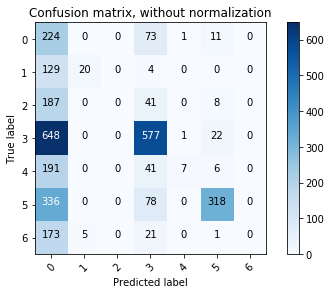

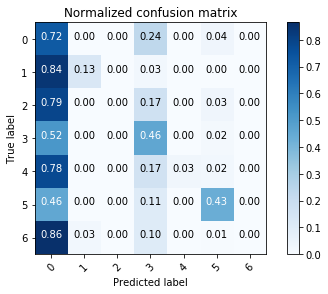

Confusion matrix, without normalization
[[22  0  0 12  0  1  0]
 [14  4  0  0  0  0  0]
 [27  0  0  0  0  0  0]
 [88  0  0 50  0  1  0]
 [22  0  0  2  0  4  0]
 [39  0  0 13  0 30  0]
 [19  1  0  3  0  0  0]]
Normalized confusion matrix
[[0.62857143 0.         0.         0.34285714 0.         0.02857143
  0.        ]
 [0.77777778 0.22222222 0.         0.         0.         0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.63309353 0.         0.         0.35971223 0.         0.00719424
  0.        ]
 [0.78571429 0.         0.         0.07142857 0.         0.14285714
  0.        ]
 [0.47560976 0.         0.         0.15853659 0.         0.36585366
  0.        ]
 [0.82608696 0.04347826 0.         0.13043478 0.         0.
  0.        ]]


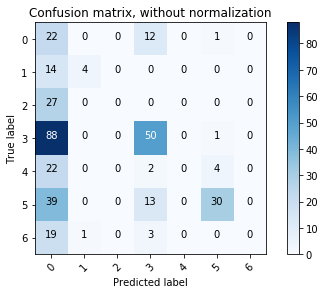

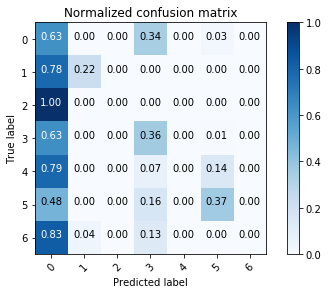

Wall time: 12min 26s


In [21]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_FNM128, y_rt_FNM128, num_categories=7)


model_rt, history_rt, test_scores_rt = run_Xception_with_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [22]:
print("right_top result accuracy:", test_scores_rt[1])

right_top result accuracy: 0.5056818181818182


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 229383    
Total params: 21,090,863
Trainable params: 21,036,335
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 63s 20ms/step - loss: 1.7022 - acc: 0.4348 - val_loss: 2.7162 - val_acc: 0.3750
Epoch 2/300
3123/3123 [==============================] - 53s 17ms/st

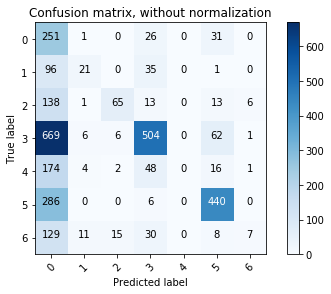

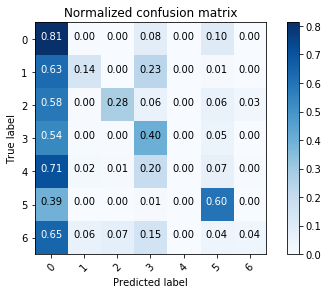

Confusion matrix, without normalization
[[29  0  0  3  0  3  0]
 [13  1  0  4  0  0  0]
 [ 5  1 19  0  0  1  1]
 [78  0  0 50  0 11  0]
 [13  0  0 14  0  1  0]
 [28  0  0  0  0 54  0]
 [ 9  0  5  6  0  2  1]]
Normalized confusion matrix
[[0.82857143 0.         0.         0.08571429 0.         0.08571429
  0.        ]
 [0.72222222 0.05555556 0.         0.22222222 0.         0.
  0.        ]
 [0.18518519 0.03703704 0.7037037  0.         0.         0.03703704
  0.03703704]
 [0.56115108 0.         0.         0.35971223 0.         0.07913669
  0.        ]
 [0.46428571 0.         0.         0.5        0.         0.03571429
  0.        ]
 [0.34146341 0.         0.         0.         0.         0.65853659
  0.        ]
 [0.39130435 0.         0.2173913  0.26086957 0.         0.08695652
  0.04347826]]


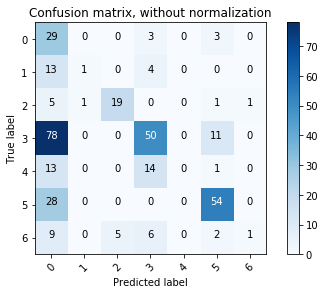

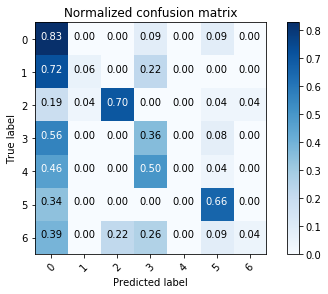

Wall time: 14min 38s


In [23]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_FNM128, y_lb_FNM128, num_categories=7)


model_lb, history_lb, test_scores_lb = run_Xception_with_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [24]:
print("left_bottom result accuracy:", test_scores_lb[1])

left_bottom result accuracy: 0.5653409090909091


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 229383    
Total params: 21,090,863
Trainable params: 21,036,335
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 73s 23ms/step - loss: 1.5651 - acc: 0.4749 - val_loss: 2.8994 - val_acc: 0.3381
Epoch 2/300
3123/3123 [==============================] - 45s 15ms/st

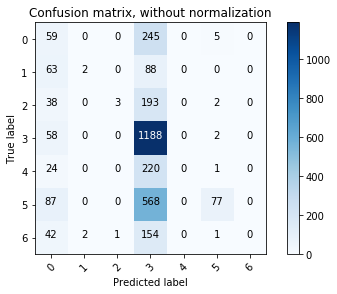

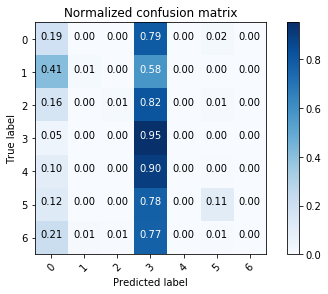

Confusion matrix, without normalization
[[  4   0   0  31   0   0   0]
 [  4   0   0  14   0   0   0]
 [  2   0   1  23   0   1   0]
 [  4   0   0 135   0   0   0]
 [ 13   0   0  14   0   1   0]
 [ 12   0   0  53   0  17   0]
 [  8   0   0  15   0   0   0]]
Normalized confusion matrix
[[0.11428571 0.         0.         0.88571429 0.         0.
  0.        ]
 [0.22222222 0.         0.         0.77777778 0.         0.
  0.        ]
 [0.07407407 0.         0.03703704 0.85185185 0.         0.03703704
  0.        ]
 [0.02877698 0.         0.         0.97122302 0.         0.
  0.        ]
 [0.46428571 0.         0.         0.5        0.         0.03571429
  0.        ]
 [0.14634146 0.         0.         0.64634146 0.         0.20731707
  0.        ]
 [0.34782609 0.         0.         0.65217391 0.         0.
  0.        ]]


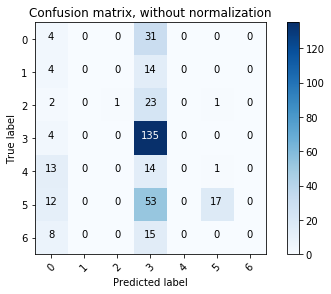

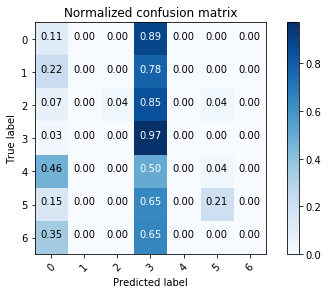

Wall time: 10min 41s


In [26]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_FNM128, y_rb_FNM128, num_categories=7)


model_rb, history_rb, test_scores_rb = run_Xception_with_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [27]:
print("right_bottom result accuracy:", test_scores_rb[1])

right_bottom result accuracy: 0.4630681818181818


## Validation accuracy results

In [28]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.5767
left_top result accuracy: 0.5909
right_top result accuracy: 0.5057
left_bottom result accuracy: 0.5653
right_bottom result accuracy: 0.4631


In [29]:
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_lt.predict(X_rt_train)
predict_result_rt_test = model_lt.predict(X_rt_test)

predict_result_lb_train = model_lt.predict(X_lb_train)
predict_result_lb_test = model_lt.predict(X_lb_test)

predict_result_rb_train = model_lt.predict(X_rb_train)
predict_result_rb_test = model_lt.predict(X_rb_test)

In [30]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(3123, 35)


In [31]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(352, 35)


In [32]:
# than write this arrays into file
file_path_un_train = "./un_train_France_ByMeaning128.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./un_test_France_ByMeaning128.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./y_train_France_ByMeaning128.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./y_test_France_ByMeaning128.npy"
np.save(file_path_y_test, y_ct_test)

In [35]:
#np.load(file_path_un_train)

test accuracy:  0.5455

Confusion matrix, without normalization
[[207   1   0  69   4  28   0]
 [ 44 102   0   4   0   1   2]
 [130   4  57  18   1  21   5]
 [230   9   1 951   5  50   2]
 [107   6   0  28  87  15   2]
 [126   0   0  20   2 584   0]
 [100  10  10  26   1  12  41]]
Normalized confusion matrix
[[0.66990291 0.00323625 0.         0.22330097 0.01294498 0.09061489
  0.        ]
 [0.2875817  0.66666667 0.         0.02614379 0.         0.00653595
  0.0130719 ]
 [0.55084746 0.01694915 0.24152542 0.07627119 0.00423729 0.08898305
  0.02118644]
 [0.18429487 0.00721154 0.00080128 0.76201923 0.00400641 0.0400641
  0.00160256]
 [0.43673469 0.0244898  0.         0.11428571 0.35510204 0.06122449
  0.00816327]
 [0.17213115 0.         0.         0.0273224  0.00273224 0.79781421
  0.        ]
 [0.5        0.05       0.05       0.13       0.005      0.06
  0.205     ]]


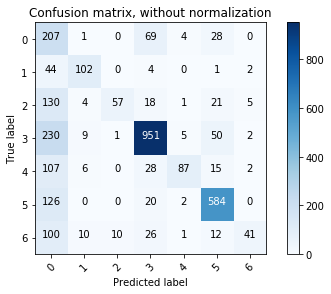

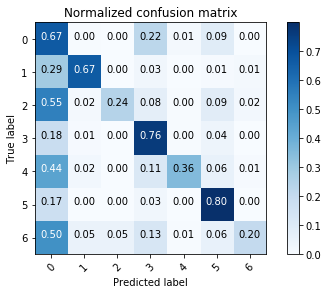

Confusion matrix, without normalization
[[17  0  0 13  0  5  0]
 [ 7  9  0  2  0  0  0]
 [ 8  0 11  0  0  7  1]
 [31  1  0 98  2  7  0]
 [14  0  0  5  2  5  2]
 [18  0  0  0  0 64  0]
 [12  4  2  2  0  0  3]]
Normalized confusion matrix
[[0.48571429 0.         0.         0.37142857 0.         0.14285714
  0.        ]
 [0.38888889 0.5        0.         0.11111111 0.         0.
  0.        ]
 [0.2962963  0.         0.40740741 0.         0.         0.25925926
  0.03703704]
 [0.22302158 0.00719424 0.         0.70503597 0.01438849 0.05035971
  0.        ]
 [0.5        0.         0.         0.17857143 0.07142857 0.17857143
  0.07142857]
 [0.2195122  0.         0.         0.         0.         0.7804878
  0.        ]
 [0.52173913 0.17391304 0.08695652 0.08695652 0.         0.
  0.13043478]]


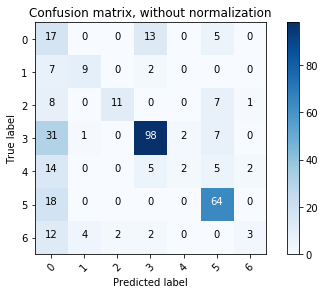

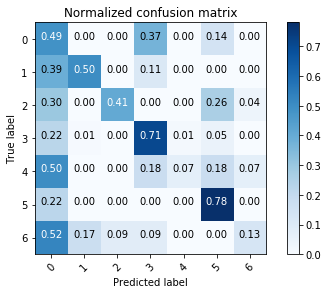

In [33]:
#let's try KNN first
categories_count = 7

knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn_uniform_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_uniform_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_uniform_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_uniform_15)
print("")

print_confusion_matrix(knn_uniform_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [34]:
knn_uniform_15_predict_train = knn_uniform_15.predict(predict_un_train)
knn_uniform_15_predict_test = knn_uniform_15.predict(predict_un_test)

file_path_knn_uniform_15_train = "./knn_uniform_15_train_Xception_France_ByMeaning128.npy"
np.save(file_path_knn_uniform_15_train, knn_uniform_15_predict_train)

file_path_knn_uniform_15_test = "./knn_uniform_15_test_Xception_France_ByMeaning128.npy"
np.save(file_path_knn_uniform_15_test, knn_uniform_15_predict_test)


test accuracy:  0.5483

Confusion matrix, without normalization
[[ 309    0    0    0    0    0    0]
 [   0  153    0    0    0    0    0]
 [   0    0  236    0    0    0    0]
 [   0    0    0 1248    0    0    0]
 [   0    0    0    0  245    0    0]
 [   0    0    0    0    0  732    0]
 [   0    0    0    0    0    0  200]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


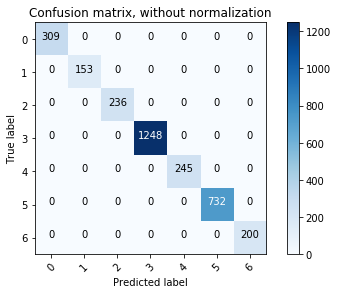

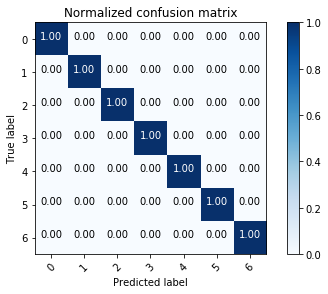

Confusion matrix, without normalization
[[17  0  0 13  0  5  0]
 [ 7  9  0  2  0  0  0]
 [ 7  0 12  0  0  7  1]
 [31  1  0 98  2  7  0]
 [ 4  0  0 15  2  5  2]
 [18  0  0  0  0 64  0]
 [12  4  2  2  0  0  3]]
Normalized confusion matrix
[[0.48571429 0.         0.         0.37142857 0.         0.14285714
  0.        ]
 [0.38888889 0.5        0.         0.11111111 0.         0.
  0.        ]
 [0.25925926 0.         0.44444444 0.         0.         0.25925926
  0.03703704]
 [0.22302158 0.00719424 0.         0.70503597 0.01438849 0.05035971
  0.        ]
 [0.14285714 0.         0.         0.53571429 0.07142857 0.17857143
  0.07142857]
 [0.2195122  0.         0.         0.         0.         0.7804878
  0.        ]
 [0.52173913 0.17391304 0.08695652 0.08695652 0.         0.
  0.13043478]]


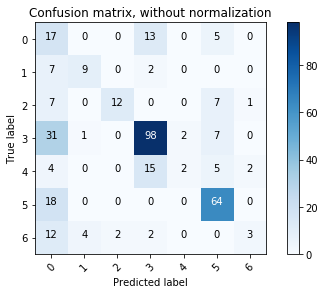

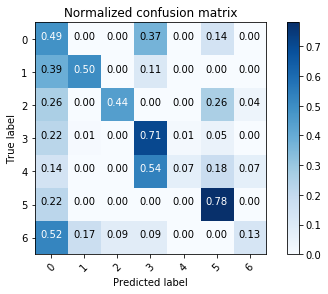

In [35]:
#let's try KNN with another weights
categories_count = 7

knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [36]:
knn_distance_15_predict_train = knn_distance_15.predict(predict_un_train)
knn_distance_15_predict_test = knn_distance_15.predict(predict_un_test)

file_path_knn_distance_15_train = "./knn_distance_15_train_Xception_France_ByMeaning128.npy"
np.save(file_path_knn_distance_15_train, knn_distance_15_predict_train)

file_path_knn_distance_15_test = "./knn_distance_15_test_Xception_France_ByMeaning128.npy"
np.save(file_path_knn_distance_15_test, knn_distance_15_predict_test)


In [37]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.6165



In [38]:
svm_predict_train = svm.predict(predict_un_train)
svm_predict_test = svm.predict(predict_un_test)

file_path_svm_train = "./svm_train_Xception_France_ByMeaning128.npy"
np.save(file_path_svm_train, svm_predict_train)

file_path_svm_test = "./svm_test_Xception_France_ByMeaning128.npy"
np.save(file_path_svm_test, svm_predict_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               18432     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 1799      
Total params: 151,559
Trainable params: 151,559
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 20s 6ms/step - loss: 1.0452

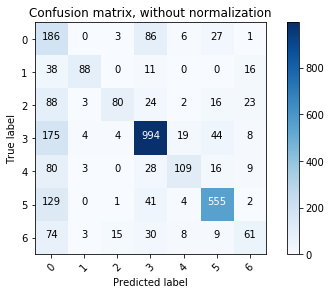

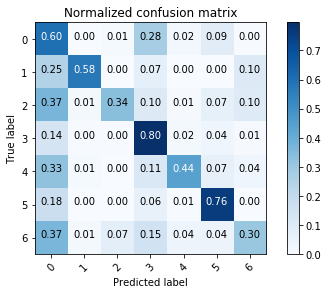

Confusion matrix, without normalization
[[ 12   0   0  19   0   4   0]
 [  3   7   0   5   0   0   3]
 [  4   0  13   2   0   7   1]
 [ 26   0   0 107   0   6   0]
 [ 15   0   0   3   2   4   4]
 [ 22   0   0   1   0  59   0]
 [ 10   1   3   2   1   0   6]]
Normalized confusion matrix
[[0.34285714 0.         0.         0.54285714 0.         0.11428571
  0.        ]
 [0.16666667 0.38888889 0.         0.27777778 0.         0.
  0.16666667]
 [0.14814815 0.         0.48148148 0.07407407 0.         0.25925926
  0.03703704]
 [0.18705036 0.         0.         0.76978417 0.         0.04316547
  0.        ]
 [0.53571429 0.         0.         0.10714286 0.07142857 0.14285714
  0.14285714]
 [0.26829268 0.         0.         0.01219512 0.         0.7195122
  0.        ]
 [0.43478261 0.04347826 0.13043478 0.08695652 0.04347826 0.
  0.26086957]]


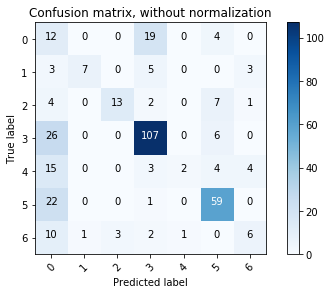

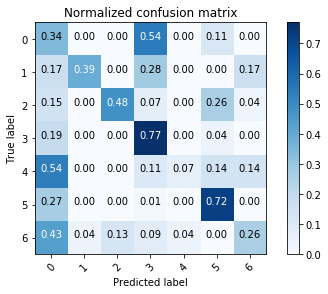

Wall time: 2min 15s


In [39]:
%%time
# and also multilayer neuron net
categories_count = 7

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

In [40]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.6733
best test accuracy: 0.6818


In [41]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./meta_net_train_Xception_France_ByMeaning128.npy"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./meta_net_test_Xception_ByMeaning128.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)
